In [1]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [2]:
TRAIN_DIR = r'/tmp/mnist'

In [3]:
from tensorflow.contrib.learn.python.learn.datasets import mnist
datasets = mnist.read_data_sets(TRAIN_DIR, one_hot=True)

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
# alternatively
# from tensorflow.examples.tutorials.mnist import input_data
# datasets2 = input_data.read_data_sets(TRAIN_DIR, one_hot=True)

In [5]:
# each image has 28*28, number of images undefined (None)
# shape is unnecessary, but helps with debugging process
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Mnist simple

In [5]:
W = tf.Variable(tf.zeros([784, 10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b')

In [34]:
sess.run(tf.global_variables_initializer())
y = tf.matmul(x, W) + b

In [35]:
# define loss and training op
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

train_op = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [37]:
# training
for _ in range(1000):
    batch = datasets.train.next_batch(100)
    sess.run(train_op, feed_dict={
            x: batch[0],
            y_: batch[1]
        })

In [89]:
# define accuracy op
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [90]:
sess.run(accuracy, feed_dict={
        x: datasets.test._images,
        y_: datasets.test._labels
    })

0.91850001

# 92%! Not very impressive... Can we do better?

In [6]:
# convenience function to create weights and biases
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [7]:
# define conv2d and max_pooling, keep code clean
def conv2d(x, W):
    # zero padding
    return tf.nn.conv2d(x, W, 
                        strides=[1, 1, 1, 1], 
                        padding='SAME') 

def max_pool_2x2(x):
    return tf.nn.max_pool(x, 
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], 
                          padding='SAME')

In [8]:
# 5x5 patch, 1 channel (grayscale), 32 filters
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


In [9]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [10]:
# conv2 dimensions: NHWC format
# input:  images x height_in   x width_in  x channels
# filter:          height_f    x width_f   x channels x filters
# output: images x height_out  x width_out            x filters
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [11]:
print(h_conv1.get_shape())
print(h_pool1.get_shape())

(?, 28, 28, 32)
(?, 14, 14, 32)


In [12]:
# 64 features
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [13]:
print(h_conv2.get_shape())
print(h_pool2.get_shape())

(?, 14, 14, 64)
(?, 7, 7, 64)


In [14]:
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [15]:
print(h_fc1.get_shape())

(?, 1024)


In [16]:
# Dropout
# placeholder store the probability of survival
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [17]:
print(h_fc1_drop.get_shape())

(?, 1024)


In [18]:
# Readout
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [19]:
print(y_conv.get_shape())

(?, 10)


In [20]:
# Use Adam (adaptive momentum estimation)
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, 
                                            logits=y_conv))
train_op_pro = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y_conv, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [30]:
train_accuracies = []
valid_accuracies = []

In [31]:
sess.run(tf.global_variables_initializer())
for i in range(2000):
    batch = datasets.train.next_batch(50)
    batch_valid = datasets.validation.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(
            feed_dict={
                x: batch[0],
                y_: batch[1],
                keep_prob: 1.0
        })
        train_accuracies.append(train_accuracy)
        valid_accuracy = accuracy.eval(
            feed_dict={
                x: batch_valid[0],
                y_: batch_valid[1],
                keep_prob: 1.0
        })
        valid_accuracies.append(valid_accuracy)
        print('step {}, training {:.2f}, valid {:.2f}'
              .format(i, train_accuracy, valid_accuracy))

    train_op_pro.run(feed_dict={
            x: batch[0],
            y_: batch[1],
            keep_prob: 0.5
        })


step 0, training 0.12, valid 0.10
step 100, training 0.92, valid 0.86
step 200, training 0.94, valid 0.90
step 300, training 0.90, valid 0.92
step 400, training 0.94, valid 0.92
step 500, training 0.92, valid 0.92
step 600, training 0.96, valid 0.96
step 700, training 0.94, valid 0.86
step 800, training 0.94, valid 0.94
step 900, training 0.96, valid 0.96
step 1000, training 0.98, valid 0.98
step 1100, training 0.96, valid 1.00
step 1200, training 0.96, valid 0.96
step 1300, training 0.94, valid 0.96
step 1400, training 0.98, valid 0.98
step 1500, training 0.96, valid 0.94
step 1600, training 1.00, valid 0.96
step 1700, training 0.96, valid 0.98
step 1800, training 1.00, valid 1.00
step 1900, training 0.98, valid 0.96


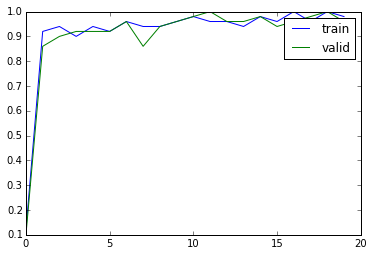

In [37]:
import matplotlib.pylab as plt
%matplotlib inline
plt.plot(train_accuracies, label='train')
plt.plot(valid_accuracies, label='valid')
plt.legend()

In [36]:
t1 = time.time()
test_accuracy = accuracy.eval(feed_dict={
        x: datasets.test.images[:5000],
        y_: datasets.test.labels[:5000],
        keep_prob: 1.0
    })
test_accuracy

In [38]:
test_accuracy

0.9648